# Customer Clustering with KMeans to Boost Business Strategy
In this notebook it will be showned how to use the KMeans algorithm to cluster customer data.


In [1]:
## Installing Required Libraries.
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

### Exploring the data

In [2]:
#Loading the data in a csv file into a dataframe.
df_sst = pd.read_csv('Wholesale customers data.csv')

#First five rows is showned
df_sst.head(5)


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [3]:
#Showing the shape of the dataset.
df_sst.shape

(440, 8)

array([[<AxesSubplot:title={'center':'Channel'}>,
        <AxesSubplot:title={'center':'Region'}>,
        <AxesSubplot:title={'center':'Fresh'}>],
       [<AxesSubplot:title={'center':'Milk'}>,
        <AxesSubplot:title={'center':'Grocery'}>,
        <AxesSubplot:title={'center':'Frozen'}>],
       [<AxesSubplot:title={'center':'Detergents_Paper'}>,
        <AxesSubplot:title={'center':'Delicassen'}>, <AxesSubplot:>]],
      dtype=object)

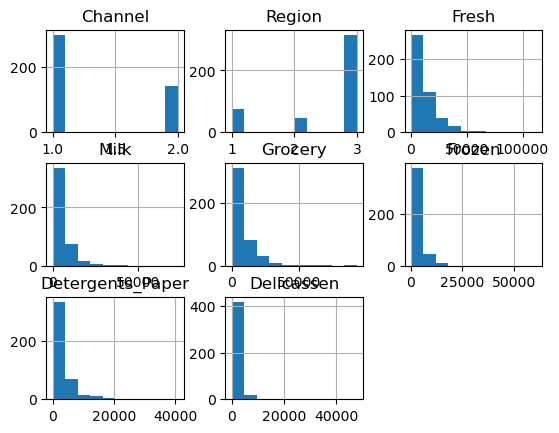

In [ ]:
#Plotting the data into histograms.
df_sst.hist()

### Deciding how many clusters to create

In [5]:
number_of_clusters = 3

In [6]:
#Create a KMeans clustering model.
cluster = KMeans(n_clusters = number_of_clusters)

In [7]:
#Training the model.
result = cluster.fit_transform(df_sst)

/home/andy/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [8]:
#Cluster centers are printed.
cluster.cluster_centers_

array([[1.96000000e+00, 2.44000000e+00, 8.00004000e+03, 1.85114200e+04,
        2.75739000e+04, 1.99668000e+03, 1.24073600e+04, 2.25202000e+03],
       [1.26060606e+00, 2.55454545e+00, 8.25346970e+03, 3.82460303e+03,
        5.28045455e+03, 2.57266061e+03, 1.77305758e+03, 1.13749697e+03],
       [1.13333333e+00, 2.56666667e+00, 3.59414000e+04, 6.04445000e+03,
        6.28861667e+03, 6.71396667e+03, 1.03966667e+03, 3.04946667e+03]])

### Making Predictions

In [9]:
#Ckecking columns name.
df_sst.columns.tolist()

['Channel',
 'Region',
 'Fresh',
 'Milk',
 'Grocery',
 'Frozen',
 'Detergents_Paper',
 'Delicassen']

In [ ]:
#Making predictions and saving them into the column "cluster_number".
df_sst['cluster_number'] = cluster.predict(df_sst)
df_sst.sample(5)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,cluster_number
207,2,1,2541,4737,6089,2946,5316,120,1
323,1,2,13360,944,11593,915,1679,573,1
311,1,2,29635,2335,8280,3046,371,117,2
99,1,3,9658,2182,1909,5639,215,323,1
258,1,1,56083,4563,2124,6422,730,3321,2


In [12]:
#Printing the cluster numbers and the number of customers in each cluster.
df_sst.cluster_number.value_counts()

cluster_number
1    330
2     60
0     50
Name: count, dtype: int64

In [18]:
# Generate sample data for clustering
X, y = make_blobs(n_samples=440, centers=3, cluster_std=0.6, random_state=0)

In [19]:
# Apply k-means clustering
cluster.fit(X)

/home/andy/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=3)

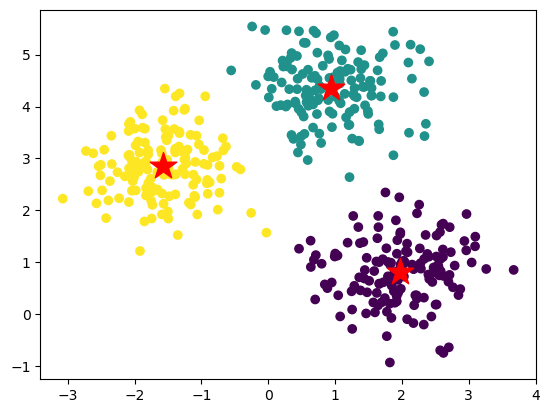

In [20]:
# Plotting the clusters and cluster centers
plt.scatter(X[:, 0], X[:, 1], c=cluster.labels_, cmap='viridis')
plt.scatter(cluster.cluster_centers_[:, 0], cluster.cluster_centers_[:, 1], marker='*', s=400, color='r')
plt.show()